# Data Dictionary

This dataset has been populated by large number of eBay auctions of a popular product. 
The dataset can be downloaded from this [link](https://archive.ics.uci.edu/ml/datasets/Shill+Bidding+Dataset)

### Attribute Information:

- Record ID: Unique identifier of a record in the dataset.
- Auction ID: Unique identifier of an auction.
- Bidder ID: Unique identifier of a bidder.
- Bidder Tendency: A shill bidder participates exclusively in auctions of few sellers rather than a diversified lot. This is a collusive act involving the fraudulent seller and an accomplice.
- Bidding Ratio: A shill bidder participates more frequently to raise the auction price and attract higher bids from legitimate participants.
- Successive Outbidding: A shill bidder successively outbids himself even though he is the current winner to increase the price gradually with small consecutive increments.
- Last Bidding: A shill bidder becomes inactive at the last stage of the auction (more than 90\% of the auction duration) to avoid winning the auction.
- Auction Bids: Auctions with SB activities tend to have a much higher number of bids than the average of bids in concurrent auctions.
- Auction Starting Price: a shill bidder usually offers a small starting price to attract legitimate bidders into the auction.
- Early Bidding: A shill bidder tends to bid pretty early in the auction (less than 25\% of the auction duration) to get the attention of auction users.
- Winning Ratio: A shill bidder competes in many auctions but hardly wins any auctions.
- Auction Duration: How long an auction lasted.
- Class: 0 for normal behaviour bidding; 1 for otherwise.


The purpose of the this analysis is to find the patterns to group the data points into their similary traits cluster.

### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.metrics import silhouette_samples, silhouette_score, homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score
from scipy.spatial import distance_matrix 
import time
import sklearn.metrics as metrics
from sklearn.cluster import MiniBatchKMeans, KMeans, AgglomerativeClustering, OPTICS, MeanShift, estimate_bandwidth, DBSCAN, AffinityPropagation ,SpectralClustering
from sklearn.metrics.pairwise import pairwise_distances_argmin
import scipy.cluster.hierarchy as hcluster
from  scipy.cluster import hierarchy
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import matplotlib.cm as cm
import functions
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("data/Shill Bidding Dataset.csv")

print("data size : {} ".format(df.shape))

data size : (6321, 13) 


In [3]:
df.tail()

,Record_ID,Auction_ID,Bidder_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
6316,15129,760,l***t,0.333333,0.160000,1.0,0.738557,0.280000,0.993593,0.686358,0.888889,3,1
6317,15137,2481,s***s,0.030612,0.130435,0.0,0.005754,0.217391,0.993593,0.000010,0.878788,7,0
6318,15138,2481,h***t,0.055556,0.043478,0.0,0.015663,0.217391,0.993593,0.015663,0.000000,7,0
6319,15139,2481,d***d,0.076923,0.086957,0.0,0.068694,0.217391,0.993593,0.000415,0.000000,7,0
6320,15144,2481,a***l,0.016393,0.043478,0.0,0.340351,0.217391,0.993593,0.340351,0.000000,7,0


### Data Preprocessing


For this dataset, the Data Preprocessing steps include:

- Removal of valueless columns.
- Updating empty values with the mean of the respective column.
- Checking for outliers.
- Standardize the dataset by using min-max scaler.
- Reduceing the number of dimensions in the training dataset using PCA.

Here we are droping the ID and date column which is a unique identifier for each row.

In [4]:
df.drop(['Record_ID','Auction_ID','Bidder_ID','Auction_Duration'], axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6321 entries, 0 to 6320
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Bidder_Tendency         6321 non-null   float64
 1   Bidding_Ratio           6321 non-null   float64
 2   Successive_Outbidding   6321 non-null   float64
 3   Last_Bidding            6321 non-null   float64
 4   Auction_Bids            6321 non-null   float64
 5   Starting_Price_Average  6321 non-null   float64
 6   Early_Bidding           6321 non-null   float64
 7   Winning_Ratio           6321 non-null   float64
 8   Class                   6321 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 444.6 KB


From the above statistics, we can observe that the dataset has the target variable which has a data type of int64, meaning we would not need encoding for that. After removing the ID and date column, dataset has 6321 rows and 8 columns with no missing values, which means we won't have to handle them.


In [6]:
numerical_df = df.select_dtypes(include=['float64'])

In [7]:
df.describe()

,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Class
count,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000
mean,0.142541,0.127670,0.103781,0.463119,0.231606,0.472821,0.430683,0.367731,0.106787
std,0.197084,0.131530,0.279698,0.380097,0.255252,0.489912,0.380785,0.436573,0.308867
min,0.000000,0.011765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.027027,0.043478,0.000000,0.047928,0.000000,0.000000,0.026620,0.000000,0.000000
50%,0.062500,0.083333,0.000000,0.440937,0.142857,0.000000,0.360104,0.000000,0.000000
75%,0.166667,0.166667,0.000000,0.860363,0.454545,0.993593,0.826761,0.851852,0.000000
max,1.000000,1.000000,1.000000,0.999900,0.788235,0.999935,0.999900,1.000000,1.000000


From the above statistical sumary we can observe that values for each column is in a range from 0 to 1.
Last_Bidding seem to follow the normal distribution. And the dependent variable Class is more represented by 0 class than 1 as mean equals 0.1 and 75% of the data has value 0. It means that the data is imbalanced and we will have to decide how to deal with this. Let's see how many observations we have represented for each class.

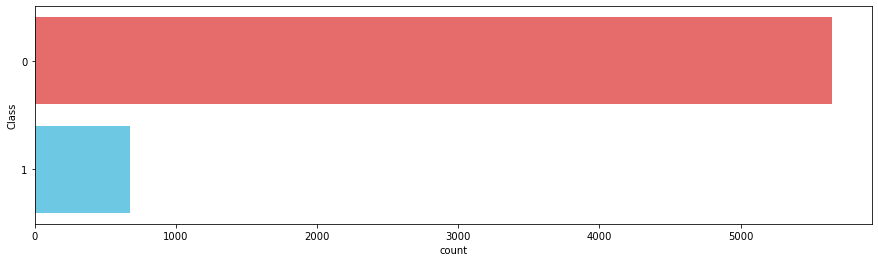

In [8]:
plt.figure(1 , figsize = (15 , 4))
color_palette = ["#FA5858", "#58D3F7", "#704041", "#f5c3c4"]
sns.countplot(y = 'Class' , data = df, palette = color_palette)
plt.show()

From the above graph, we can see that 0 class has above 5000 entries while 1 class has less tha 1000 entries. .


#####  plot distribution of numerical attributes

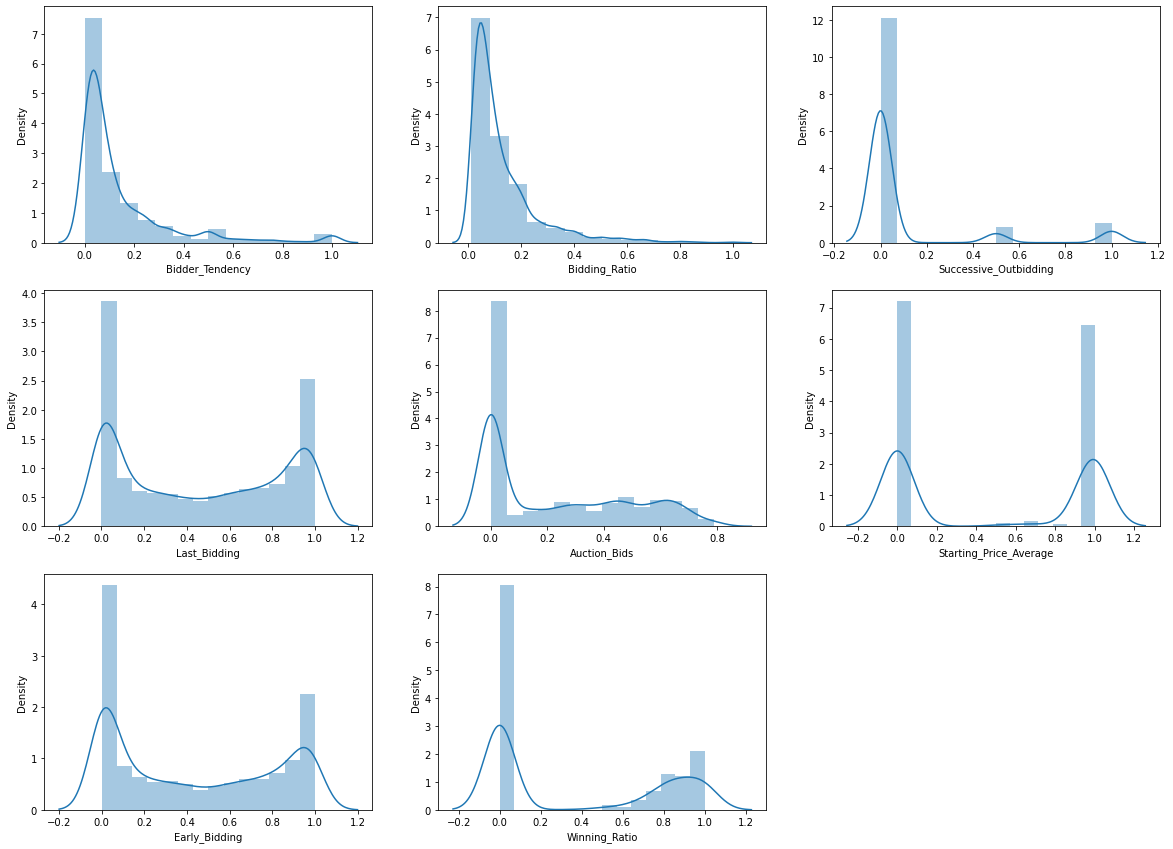

In [10]:
numerical_attributes_plot_distrbution(df)

From the above analysis, Bidder_Tendency and Bidding_Ratio have many outliers. And  Last_Bidding, and Early_Bidding seem to follow normal distribution.

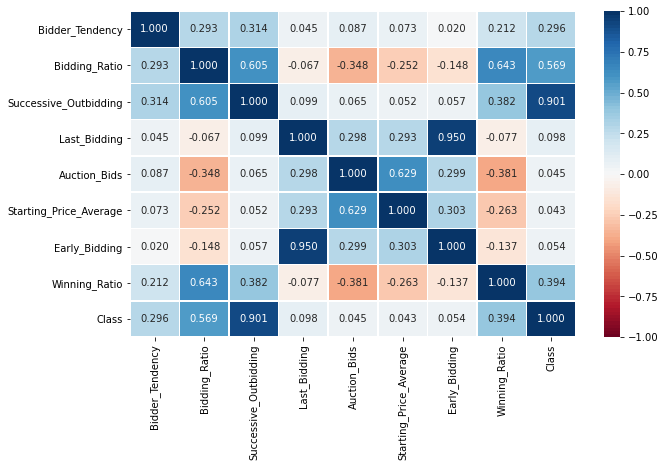

In [12]:
plot_corr_matrix(df)

- Successive_Outbidding and Class are highly correlated with 0.901 value.
- Last_Bidding and Early_Bidding columns are highly correlated with 0.954 value.

Since A shill bidder becomes inactive at the last stage of the auction (more than 90% of the auction duration) to avoid winning the auction, and it is highly correlated with Early_Bidding, we can remove this column


In [159]:
df.drop(['Last_Bidding'], axis=1, inplace=True)

#### Checking for Outliers

Here we are checking for all the outliers, by getting each variable upper and lower extream values and removing which does not lie in IQR Range

In [160]:
cleaned_data = process_outliers(numerical_df)
len(cleaned_data)

6321

In [162]:
cleaned_data.tail()

,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio
6316,0.333333,0.160000,1.0,0.738557,0.280000,0.993593,0.686358,0.888889
6317,0.030612,0.130435,0.0,0.005754,0.217391,0.993593,0.000010,0.878788
6318,0.055556,0.043478,0.0,0.015663,0.217391,0.993593,0.015663,0.000000
6319,0.076923,0.086957,0.0,0.068694,0.217391,0.993593,0.000415,0.000000
6320,0.016393,0.043478,0.0,0.340351,0.217391,0.993593,0.340351,0.000000


In [163]:
X = cleaned_data.loc[:, cleaned_data.columns != 'Class']
y = df[['Class']]

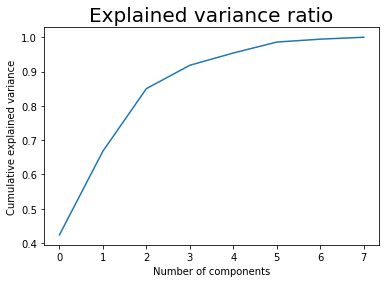

In [165]:
plot_PCA_graph(X)

Here we have used PCA on the raw data, as observed from the above graph, the number of componets are analyzed based on how variance is explained for each principle componets and the business goal. For our analysis, let's try to secure 90% of the explained variance.

Since selecting the best number of principal components is to keep as much of the variance in the original data as possible, we would be going for the 3 paramters which is much less than our original dataset which has 9 attributes in total. From the above grap, the first 3 components for the 90% of variance can be used instead of using all the features in the dataset. This way dimension of data has been reduced by 75%, meaning that it will be now easier to fit clustering models as they are mainly based on distances.

In [118]:
pca = PCA(n_components=3)
projected = pca.fit_transform(X)
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.4412566 , 0.24644292, 0.20145624])

In [119]:
principal_df = pd.DataFrame(data = projected)
df_pca = principal_df.join(y, how='outer')
df_pca.head(5)

,0,1,2,Class
0,-0.162563,-0.408690,0.644242,0
1,-0.233269,-0.287493,0.771257,0
2,-0.261386,-0.261509,0.828819,0
3,-0.186979,-0.162766,0.779626,0
4,-0.738498,-0.261581,-0.080851,0


In [120]:
df1 = df_pca.dropna()
X = df1.loc[:, df1.columns != 'Class']
y = df1[['Class']]

In [121]:
X = X[:300]
X.shape

(300, 3)

In [122]:
y = y[:300]
y.shape

(300, 1)

# Cluster Analysis

This section is divided into two parts. In the first part we will be doing a comparative analysis of Gaussian mixture model with it's paramter's best value using Grid Search Technique. And In the second part we will be performing a comparartive analysis of <b>Gaussian mixture model </b> with other models that include <b>Bayesian Gaussian Mixture, Mini-Batch K-means, OPTICS, DBSCAN, Agglomerative, Spectral Clustering and Affinity Propagation </b> with their respective hyper-paramter tuning using Grid Search Technique. No of best paramters would be chosen on the basis of maximum silhoutte score.

We will be further evaulating our cluster performance using following measures: 
    
###### Intrinsic Measures that does not require ground truth labels (y)
- silhouette_score measures the between-cluster distance against within-cluster distance. A higher score signifies better-defined clusters. It is good for well define cluster as well as measure the interpretability of clusters.
- davies_bouldin_score measures the size of clusters against the average distance between clusters. A lower score signifies better-defined clusters. A lower score means that the cluster is relatively small compared to the distance to another cluster, hence well-defined.
- calinski_harabasz_score measures the between-cluster dispersion against within-cluster dispersion. A higher score signifies better-defined clusters. A higher ratio signifies the cluster is far away from its other clusters and that the cluster is more well-defined
    
    
###### Extrinsic Measures that requires ground truth labels (y)
- fowlkes_mallows_score measure the correctness of the cluster assignments using pairwise precision and recall. A higher score signifies higher similarity.
- adjusted_rand_score measures the similarity between the cluster assignments by making pair-wise comparisons. A higher score signifies higher similarity.
- adjusted_mutual_info_score measures the agreement between the cluster assignments. A higher score signifies higher similarity.
- homogeneity_score measures the precision of cluster, meaning each cluster contains only members of a single class. 
- completeness_score measures the recall of cluster, meaning all members of a given class are assigned to the same cluster.
- v_measure_score measures the correctness of the cluster assignments and used to measure interpretability of clusters. A higher score signifies higher similarity.


## Part 1: Comparative Analysis of Gaussian mixture model with it's hyper-parameters

A Gaussian mixture model (GMM) assists to find a mixture of multi-dimensional Gaussian probability distributions that best models dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means.

Here, first we would only be applying Gaussian Mixture Model with 2 components, then with addition of each hyperparamter using Grid Search to get the best possible attribute combination, we would be doing a comparative analysis as how each parameter is effecting the result of clustering. We would be doing comparative analysis using

- GMM with n_components = 2
- GMM with n_components and covariance_type using Grid Search 
- GMM with n_components and max_iter using Grid Search 
- GMM with n_components and init_params using Grid Search 
- GMM with n_components and n_init using Grid Search 


#### GMM with n_components = 2

n_components refers to the number of mixture components.

First we would just be using fixed no of n_components with all the default parameters to see how the clusers are formed for our dataset.

In [123]:
gmm1 = GaussianMixture(n_components = 2)

gmm1.fit(X)
gmm1_labels = gmm1.fit_predict(X)
gmm1_dataset = pd.DataFrame(X.copy())
gmm1_dataset.loc[:,'Cluster'] = gmm1_labels
gmm1_dataset.Cluster.value_counts().to_frame()

,Cluster
0,166
1,134


In [124]:
gmm_df1 = pd.DataFrame(estimator_evaluation2(gmm1, 'GaussianMixture ', X , y), index=["GaussianMixture with n_components only"])
gmm_df1

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
GaussianMixture with n_components only,0.406574,1.146124,203.324259,0.636826,0.006318,0.000128,0.004978,0.002559,0.003381


#### GMM with n_components and covariance_type using Grid Search

covariance_type parameter controls the degrees of freedom in the shape of cluster. That is what allows for adjusting for different shapes of the clusters and that is why it is an essential to set this carefully for the given problem. 


- full(default): it referes to have each component has its own general covariance matrix, which allows each cluster to be modeled as an ellipse with it's arbitrary orientation.
- tied: it referes to have all components share the same general covariance matrix.
- diag: it referes to have each component has its own diagonal covariance matrix, which means that the size of the cluster with each dimension can be set independently.
- spherical: it referes to have each component has its own single variance, which is a simpler and faster model that constrains the shape of the cluster such that all dimensions are equal. The resulting clustering will have similar characteristics to that of k-means.

We would be using the best covariance_type for our problem analysis using Grid Search Hyper-parameter technique.

In [125]:
gmm_grid = {
        "covariance_type": ['full', 'tied', 'diag', 'spherical'],
        "n_components": range(2, 10)
       }
gmm_grid
gmm_model2 = GaussianMixture()
gmm_params2 = GridSearchCV(gmm_model2,gmm_grid,scoring=silhouette_score3,cv= 10).fit(X, y)
print(gmm_params2.best_params_)
gmm2 = GaussianMixture(covariance_type = gmm_params2.best_params_['covariance_type'],
                      n_components = gmm_params2.best_params_['n_components'])

gmm2.fit(X)
gmm2_labels = gmm2.fit_predict(X)
gmm2_dataset = pd.DataFrame(X.copy())
gmm2_dataset.loc[:,'Cluster'] = gmm2_labels
gmm2_dataset.Cluster.value_counts().to_frame()

{'covariance_type': 'diag', 'n_components': 7}


,Cluster
6,62
4,51
3,47
0,38
1,37
2,34
5,31


In [126]:
gmm_df2 = pd.DataFrame(estimator_evaluation2(gmm2, 'GaussianMixture ', X , y), index=["GaussianMixture with covariance_type"])
gmm_df2

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
GaussianMixture with covariance_type,0.474505,0.77383,236.177253,0.347631,0.003665,0.08564,0.302614,0.055744,0.094145


#### GMM with n_components and max_iter using Grid Search 

max_iter refers to the number of EM iterations to perform.

As Gaussian Mixture models takes quite much time to run as compare to K-Means model because GMM takes long time to converge.
That is why we need to consider the amount of data and the features that needs to be given to GMM. When experimenting with the Bayesian Gaussian Mixture class, it often gives an errors of convergence that couldn’t be reached, in that case we need to increase the max_iter parameter.

We would be using the best max_iter for our problem analysis using Grid Search Hyper-paramter technique.

In [127]:
gmm_grid = {
        "max_iter": [50, 100, 150, 200, 250, 300],
        "n_components": range(2, 10)
       }
gmm_grid
gmm_model3 = GaussianMixture()
gmm_params3 = GridSearchCV(gmm_model3,gmm_grid,scoring=silhouette_score3,cv= 10).fit(X, y)
print(gmm_params3.best_params_)
gmm3 = GaussianMixture(max_iter = gmm_params3.best_params_['max_iter'],
                      n_components = gmm_params3.best_params_['n_components'])

gmm3.fit(X)
gmm3_labels = gmm3.fit_predict(X)
gmm3_dataset = pd.DataFrame(X.copy())
gmm3_dataset.loc[:,'Cluster'] = gmm3_labels
gmm3_dataset.Cluster.value_counts().to_frame()

{'max_iter': 200, 'n_components': 6}


,Cluster
0,81
5,62
1,49
2,47
3,38
4,23


In [128]:
gmm_df3 = pd.DataFrame(estimator_evaluation2(gmm3, 'GaussianMixture ', X , y), index=["GaussianMixture with max_iter"])
gmm_df3

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
GaussianMixture with max_iter,0.389842,1.04981,182.864487,0.396616,0.031332,0.131162,0.416842,0.082876,0.138262


#### GMM with n_components and init_params using Grid Search 

init_params refers to Initialization methods that helps to generate the initial centers for the model components. The innitial method for GMM are:

- k-means (default) :This refers to k-means clustering algorithm and can be computationally expensive compared to other initialization methods.

- k-means++ : This initialization method of k-means clustering picks the first center at random from the data, then the centers will be chosen from a weighted distribution of the data that favours points that are further away from the existing centers.

- random_from_data : This picks random data points from the input data as the initial centers, and it's fastest method of initialization but can result in producing non-convergent results if the selected points are way too close to each other.

- random : This chooses center randomly but away from the mean of all data, but as simple as it is, it can lead to the model taking longer to converge.

We would be using the best init_params for our problem analysis using Grid Search Hyper-paramter technique

In [129]:
gmm_grid = {
        "init_params": ['kmeans', 'k-means++', 'random', 'random_from_data'],
        "n_components": range(2, 10)
       }
gmm_grid
gmm_model4 = GaussianMixture()
gmm_params4 = GridSearchCV(gmm_model4,gmm_grid,scoring=silhouette_score3,cv= 10).fit(X, y)
print(gmm_params4.best_params_)
gmm4 = GaussianMixture(init_params = gmm_params4.best_params_['init_params'],
                      n_components = gmm_params4.best_params_['n_components'])

gmm4.fit(X)
gmm4_labels = gmm4.fit_predict(X)
gmm4_dataset = pd.DataFrame(X.copy())
gmm4_dataset.loc[:,'Cluster'] = gmm4_labels
gmm4_dataset.Cluster.value_counts().to_frame()

{'init_params': 'kmeans', 'n_components': 9}


,Cluster
1,56
0,55
6,53
2,48
4,32
7,20
3,14
8,12
5,10


In [130]:
gmm_df4 = pd.DataFrame(estimator_evaluation2(gmm4, 'GaussianMixture ', X , y), index=["GaussianMixture with init_params"])
gmm_df4

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
GaussianMixture with init_params,0.520798,0.672548,343.689167,0.330352,0.019314,0.080221,0.321426,0.052904,0.090855


#### GMM with n_components and n_init using Grid Search 

n_init refers to the number of initializations to be performed in GMM.

We would be using the best n_init for our problem analysis using Grid Search Hyper-paramter technique

In [131]:
gmm_grid = {
        "n_init": range(1, 6),
        "n_components": range(2, 10)
       }
gmm_grid
gmm_model5 = GaussianMixture()
gmm_params5 = GridSearchCV(gmm_model5,gmm_grid,scoring=silhouette_score3,cv= 10).fit(X, y)
print(gmm_params5.best_params_)
gmm5 = GaussianMixture(n_init = gmm_params5.best_params_['n_init'],
                      n_components = gmm_params5.best_params_['n_components'])

gmm5.fit(X)
gmm5_labels = gmm5.fit_predict(X)
gmm5_dataset = pd.DataFrame(X.copy())
gmm5_dataset.loc[:,'Cluster'] = gmm5_labels
gmm5_dataset.Cluster.value_counts().to_frame()

{'n_components': 9, 'n_init': 3}


,Cluster
0,53
1,49
5,48
6,38
3,33
7,29
4,28
8,14
2,8


In [132]:
gmm_df5 = pd.DataFrame(estimator_evaluation2(gmm5, 'GaussianMixture ', X , y), index=["GaussianMixture with n_init"])
gmm_df5

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
GaussianMixture with n_init,0.410171,0.77032,210.522723,0.337619,0.012432,0.092763,0.357639,0.060547,0.103562


In [133]:
gmm_result = gmm_df1.append([gmm_df2, gmm_df3,gmm_df4,gmm_df5])
gmm_result

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
GaussianMixture with n_components only,0.406574,1.146124,203.324259,0.636826,0.006318,0.000128,0.004978,0.002559,0.003381
GaussianMixture with covariance_type,0.474505,0.773830,236.177253,0.347631,0.003665,0.085640,0.302614,0.055744,0.094145
GaussianMixture with max_iter,0.389842,1.049810,182.864487,0.396616,0.031332,0.131162,0.416842,0.082876,0.138262
GaussianMixture with init_params,0.520798,0.672548,343.689167,0.330352,0.019314,0.080221,0.321426,0.052904,0.090855
GaussianMixture with n_init,0.410171,0.770320,210.522723,0.337619,0.012432,0.092763,0.357639,0.060547,0.103562


### Part 1 Performance Analysis:

From the above result set of all those 5 GMM model with it's different paramters, we can conclude that

- Silhoutte Score of each model seems to be higher for the GaussianMixture with init_params as it has the highest score of 0.47, while GaussianMixture with max_iter has the lowest score of 0.24. Meaning with GaussianMixture with init_params kmeans, 52% data points are quite compact within the cluster to which it belongs and far away from the other clusters
- Davies_bouldin_score seems to be good for each model but it is lowest for GaussianMixture with init_params keans, meaning the GMM has build the clusters that are farther apart and less dispersed on our dataset. 
- Calinski_harabasz_score is quite high for GaussianMixture with init_params as kmeans and n_components = 9 and all default values for other paramteres but similar for other models, means the clusters are dense and well separated.
- V-measure of each models is way less for each model, meaning GMM has failed to cluster fail the cluster correctly labelled the data.
- adjusted_rand_score is negative for all models, meaning that the clusterings that we are comparing have less in common.
 
Since the higher the silhouette value, the more certain we can be that its label is correct, GaussianMixture with init_params as kmeans has performed way better as compared to other.

## Part 2: Comparative Analysis of Gaussian Mixture Model with Bayesian Gaussian Mixture, Mini-Batch K-means, OPTICS, DBSCAN, Agglomerative, Spectral Clustering and Affinity Propagation

### Gaussian Mixture Model

A Gaussian mixture model (GMM) assists to find a mixture of multi-dimensional Gaussian probability distributions that best models dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means.

In [134]:

gmm_grid = {
        "covariance_type": ['full', 'tied', 'diag', 'spherical'],
        "max_iter": [50, 100, 150, 200, 250, 300],
        "init_params": ['kmeans', 'k-means++', 'random', 'random_from_data'],
        "n_components": range(2, 15),
        "n_init": range(1, 6)
       }
gmm_grid

{'covariance_type': ['full', 'tied', 'diag', 'spherical'],
 'max_iter': [50, 100, 150, 200, 250, 300],
 'init_params': ['kmeans', 'k-means++', 'random', 'random_from_data'],
 'n_components': range(2, 15),
 'n_init': range(1, 6)}

In [135]:
gmm_model = GaussianMixture()
gmm_params = GridSearchCV(gmm_model,gmm_grid,scoring=silhouette_score3,cv= 10).fit(X, y)

In [136]:
gmm_params.best_score_, gmm_params.best_params_

(0.6050067414344105,
 {'covariance_type': 'diag',
  'init_params': 'kmeans',
  'max_iter': 150,
  'n_components': 7,
  'n_init': 2})

In [137]:
gmm = GaussianMixture(covariance_type = gmm_params.best_params_['covariance_type'],
                      init_params = gmm_params.best_params_['init_params'],
                      n_components = gmm_params.best_params_['n_components'],
                      n_init = gmm_params.best_params_['n_init'],
                      max_iter = gmm_params.best_params_['max_iter'])

gmm.fit(X)
gmm_labels = gmm.fit_predict(X)

In [138]:
gmm_dataset = pd.DataFrame(X.copy())
gmm_dataset.loc[:,'Cluster'] = gmm_labels
gmm_dataset.Cluster.value_counts().to_frame()

,Cluster
6,62
1,51
3,47
2,38
5,37
4,34
0,31


In [139]:
gmm_df = pd.DataFrame(estimator_evaluation2(gmm, 'GaussianMixture ', X , y), index=["GaussianMixture"])
gmm_df

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
GaussianMixture,0.474505,0.77383,236.177253,0.347631,0.003665,0.08564,0.302614,0.055744,0.094145


In [140]:
# plot using tsne 
X_embedded  = TSNE(n_components=3, perplexity=10,random_state=24).fit_transform( X )
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
fig = px.scatter_3d(x=X_embedded [:,0],y=X_embedded [:,1],z=X_embedded [:,2],color=colors[gmm_labels])
fig.show()

### Bayesian Gaussian Mixture

Mixture models are useful for integrating multiple data generating processes into a single model. A gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of gaussian distributions with unknown parameters.

The Bayesian gaussian mixture is a variation of the Gaussian mixture. BGM is less sensitive to the number of parameters and it chooses effective components automatically.

In [46]:
bgm_grid = {
        "covariance_type": ['full', 'tied', 'diag', 'spherical'],
        "max_iter": [50, 100, 150, 200],
        "init_params": ['kmeans', 'k-means++', 'random', 'random_from_data'],
        "n_components": range(2, 6),
        "n_init": range(1, 5s),
        "weight_concentration_prior_type" : ['dirichlet_process', 'dirichlet_distribution']
       }

#bgm_grid

In [47]:
bgm_model = BayesianGaussianMixture()
bgm_params = GridSearchCV(bgm_model,bgm_grid,scoring=silhouette_score3,cv= 10).fit(X, y)

In [48]:
bgm_params.best_score_, bgm_params.best_params_

(0.5545617328686584,
 {'covariance_type': 'spherical',
  'init_params': 'kmeans',
  'max_iter': 200,
  'n_components': 9,
  'n_init': 1,
  'weight_concentration_prior_type': 'dirichlet_distribution'})

In [49]:
bgm = BayesianGaussianMixture(covariance_type = bgm_params.best_params_['covariance_type'],
                      init_params = bgm_params.best_params_['init_params'],
                      n_components = bgm_params.best_params_['n_components'],
                      n_init = bgm_params.best_params_['n_init'],
                      max_iter = bgm_params.best_params_['max_iter'],
                      weight_concentration_prior_type = bgm_params.best_params_['weight_concentration_prior_type'])

bgm.fit(X)
bgm_labels = bgm.fit_predict(X)

In [50]:
bgm_dataset = pd.DataFrame(X.copy())
bgm_dataset.loc[:,'Cluster'] = bgm_labels
bgm_dataset.Cluster.value_counts().to_frame()

,Cluster
5,59
2,50
4,47
3,37
7,32
1,24
8,18
6,18
0,15


In [51]:
bgm_df = pd.DataFrame(estimator_evaluation2(bgm, 'BayesianGaussianMixture ', X , y), index=["BayesianGaussianMixture"])
bgm_df

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
BayesianGaussianMixture,0.455626,0.848315,157.13025,0.351069,0.031892,0.157909,0.588145,0.097851,0.167787


In [52]:
# plot using tsne 
X_embedded  = TSNE(n_components=3, perplexity=10,random_state=24).fit_transform( X )
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
fig = px.scatter_3d(x=X_embedded [:,0],y=X_embedded [:,1],z=X_embedded [:,2],color=colors[bgm_labels])
fig.show()

### Mini-Batch Kmean Clustering

Mini Batch K-means is a variation of K-means algorithm which introduces an idea of using small random batches of data of fixed size. For each iteration, a new random sample from the dataset is taken and used to modify the clusters and this process is repeated until convergence.

In [53]:
#mbk_model.get_params().keys()

In [141]:
k_mean_grid = {
        "batch_size": [50, 100, 150, 200],
        "max_iter": [50, 100, 150, 200],
        "init": ['k-means++', 'random'],
        "n_clusters": range(2, 6),
        "n_init": range(1, 6)
       }
k_mean_grid

{'batch_size': [50, 100, 150, 200],
 'max_iter': [50, 100, 150, 200],
 'init': ['k-means++', 'random'],
 'n_clusters': range(2, 6),
 'n_init': range(1, 6)}

In [142]:
mbk_model = MiniBatchKMeans()
mbk_params = GridSearchCV(mbk_model,k_mean_grid,scoring=silhouette_score,cv= 10).fit(X, y)

In [143]:
mbk_params.best_score_, mbk_params.best_params_

(0.5854280640373941,
 {'batch_size': 50,
  'init': 'k-means++',
  'max_iter': 50,
  'n_clusters': 5,
  'n_init': 3})

In [144]:
batch_size = 45
mbk = MiniBatchKMeans(init = mbk_params.best_params_['init'],
                      n_clusters = mbk_params.best_params_['n_clusters'],
                      batch_size = mbk_params.best_params_['batch_size'],
                      n_init = mbk_params.best_params_['n_init'],
                      max_iter = mbk_params.best_params_['max_iter'],
                      max_no_improvement = 10, verbose = 0)

mbk.fit(X)
mbk_means_cluster_centers = np.sort(mbk.cluster_centers_, axis = 0)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)


In [145]:
mbk_dataset = pd.DataFrame(X.copy())
mbk_dataset.loc[:,'Cluster'] = mbk_means_labels

In [146]:
mbk_dataset.Cluster.value_counts().to_frame()

,Cluster
1,105
2,79
3,66
0,28
4,22


In [147]:
kmean_df = pd.DataFrame(estimator_evaluation(mbk, 'Mini-Batch K-means', X , y ), index=["Mini-Batch Kmean"])
kmean_df

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
Mini-Batch Kmean,0.428735,0.901368,192.045183,0.41736,0.010402,0.041837,0.133072,0.029816,0.048716


In [148]:
# plot using tsne 
X_embedded  = TSNE(n_components=3, perplexity=10,random_state=24).fit_transform( X )
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
fig = px.scatter_3d(x=X_embedded [:,0],y=X_embedded [:,1],z=X_embedded [:,2],color=colors[mbk_means_labels])
fig.show()

### Hierachical Clustering

Hierarchical clustering used to group objects in clusters based on their similar to each other. We would be using bottom-up clustering approach, where each data point is assigned to its own cluster. and then the similar clusters are merged iteratively until all of the data points are part of one big root cluster.


In [62]:
# Single linkage: 
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree


In [149]:
agg_grid = {
        "affinity": ['euclidean', 'l1', 'l2', 'manhattan', 'cosine', 'precomputed'],
        "linkage" : ['ward', 'complete', 'average', 'single'],
        "n_clusters": range(2, 7)
       }
agg_grid

{'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine', 'precomputed'],
 'linkage': ['ward', 'complete', 'average', 'single'],
 'n_clusters': range(2, 7)}

In [150]:
agg_model = AgglomerativeClustering()
agg_params = GridSearchCV(agg_model,agg_grid,scoring=silhouette_score,cv= 10).fit(X, y)

In [151]:
agg_params.best_score_, agg_params.best_params_

(0.5990028036127157,
 {'affinity': 'euclidean', 'linkage': 'ward', 'n_clusters': 6})

In [152]:
agg_clustering_model = AgglomerativeClustering(n_clusters= agg_params.best_params_['n_clusters'], 
                                               linkage= agg_params.best_params_['linkage'], 
                                               affinity =  agg_params.best_params_['affinity'])
agg_clustering_model.fit(X)
agg_labels = agg_clustering_model.labels_

In [153]:
agg_dataset = pd.DataFrame(X.copy())
agg_dataset.loc[:,'Cluster'] = agg_labels
agg_dataset.Cluster.value_counts().to_frame()

,Cluster
0,79
3,53
1,52
2,46
5,35
4,35


In [154]:
X.shape[0]

300

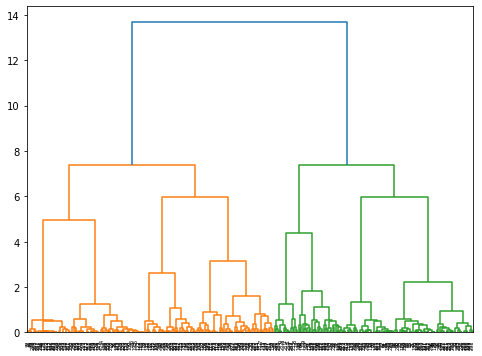

In [155]:
clusters = linkage(X, method=agg_params.best_params_['linkage'])

plt.figure(figsize=(8, 6))
dendrogram = hierarchy.dendrogram(clusters)
plt.axhline(150, color='red', linestyle='--') 
plt.axhline(100, color='crimson')

In [156]:
agg_df = pd.DataFrame(estimator_evaluation(agg_clustering_model, 'Agglomerative Clustering ', X , y ), index=["Agglomerative Clustering "])
agg_df

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
Agglomerative Clustering,0.462614,0.817684,229.679511,0.397394,0.021608,0.08356,0.271343,0.054793,0.091175


### DBSCAN

DBSCAN is a non parametric clustering algorithm which groups the closed high density data points and those points that lie in the lower density areas are treated as outliers. It does this using Epsilon Parameter (Degree of closeness of points in the same cluster) and MinPts ( Minimum number of points inside the radius of circle )

In [71]:
dbscan_grid = {
        "min_samples": range(2,20,3),
        "metric": ['euclidean','dice' 'manhattan', 'cosine', 'precomputed'],
        "algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute'],
        "eps": np.arange(0.01,3,0.01)
       }
#dbscan_grid

In [72]:
def dbscan_silhouette_score(estimator, X,y):
    clusters = estimator.fit_predict(X)
    #print("Number of labels: ",estimator,estimator.labels_)
    n = len(np.unique(estimator.labels_))
    if n>1:
        score = metrics.silhouette_score(X, estimator.labels_)
        #print("Number of labels: ",estimator,estimator.labels_)
        return score
    else:
        return 0
dbscan_model = DBSCAN()
dbscan_params = GridSearchCV(dbscan_model,dbscan_grid,scoring=dbscan_silhouette_score,cv= 10).fit(X, y)

In [73]:
dbscan_params.best_score_, dbscan_params.best_params_

(0.5221459733683752,
 {'algorithm': 'auto', 'eps': 0.12, 'metric': 'cosine', 'min_samples': 2})

In [74]:
dbscan_clustering = DBSCAN(eps= dbscan_params.best_params_['eps'], 
                    min_samples= dbscan_params.best_params_['min_samples'],
                    algorithm = dbscan_params.best_params_['algorithm'],
                    metric = dbscan_params.best_params_['metric']
                   ).fit(X)
DBSCAN_dataset = pd.DataFrame(X.copy())
DBSCAN_dataset.loc[:,'Cluster'] = dbscan_clustering.labels_ 

In [75]:
DBSCAN_dataset.Cluster.value_counts().to_frame()

,Cluster
2,126
1,100
3,64
0,8
-1,2


In [103]:
dbscan_df = pd.DataFrame(estimator_evaluation(dbscan_clustering, 'DBSCAN', X ,y), index=["DBSCAN"])
dbscan_df

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
DBSCAN,0.30243,1.210737,80.106376,0.501938,-0.021495,0.036359,0.097963,0.02909,0.044859


In [77]:
# plot using tsne 
X_embedded  = TSNE(n_components=3, perplexity=10,random_state=24).fit_transform( X )
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
fig = px.scatter_3d(x=X_embedded [:,0],y=X_embedded [:,1],z=X_embedded [:,2],color=colors[dbscan_clustering.labels_])
fig.show()

### Optics

OPTICS is also a density-based algorithm similar to DBSCAN, but as compare to DBSCAN, OPTICS can find meaningful clusters in data that varies in density. OPTICS does process by ordering the data points so that the closest points are neighbors in the ordering. 

In [78]:
optics_grid = {
        "min_samples" : range(7,20,3),
        "metric": ['euclidean','dice' 'manhattan', 'cosine', 'precomputed'],
        "algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute'],
        "eps": np.arange(0.01,1.1,0.01)
       }
#dbscan_grid

In [79]:
optics_model = OPTICS()
optics_params = GridSearchCV(optics_model,optics_grid,scoring=silhouette_score2,cv= 10).fit(X, y)

In [80]:
optics_params.best_score_, optics_params.best_params_

(0.35188272614392185,
 {'algorithm': 'auto', 'eps': 0.01, 'metric': 'cosine', 'min_samples': 7})

In [81]:
optics_clustering = OPTICS(min_samples = optics_params.best_params_['min_samples'],
                           algorithm = optics_params.best_params_['algorithm'],
                           metric = optics_params.best_params_['metric'],
                           eps = optics_params.best_params_['eps']
                          ).fit(X)
cluster = list(optics_clustering.labels_)
values, counts = np.unique(cluster, return_counts=True)      
optics_dataset = pd.DataFrame(X.copy())
optics_dataset.loc[:,'Cluster'] = optics_clustering.labels_


In [82]:
optics_dataset.Cluster.value_counts().to_frame()

,Cluster
-1,143
10,23
4,17
3,17
9,15
7,14
5,13
1,11
12,9
6,9


In [83]:

Optics_df = pd.DataFrame(estimator_evaluation(optics_clustering, 'Optics ', X , y ), index=["Optics"])
Optics_df

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
Optics,0.055677,1.092444,26.131461,0.455827,0.013619,0.12408,0.474718,0.084077,0.142853


In [84]:
# plot using tsne 
X_embedded  = TSNE(n_components=3, perplexity=10,random_state=24).fit_transform( X )
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
fig = px.scatter_3d(x=X_embedded [:,0],y=X_embedded [:,1],z=X_embedded [:,2],color=colors[optics_clustering.labels_])
fig.show()

### Spectral Clustering

Spectral CLustering is a graph based clustering technique which is used to identify communities of nodes in a graph based on the edges connecting the nodes. It uses an information from the eigenvalues of special matrices that are built from the graph/data set.

In [85]:
spectral_grid = {
        "eigen_solver" : ['arpack','amg'],
        "n_clusters" : range(2,10),
        "n_init" : range(2,6),
    
        "n_neighbors" : range(7,20,2),
        "affinity": ['nearest_neighbors','rbf' 'precomputed'],
        "assign_labels" : ['kmeans', 'discretize', 'cluster_qr'],
       }
#spectral_grid

In [87]:
spectral_model = SpectralClustering()
spectral_params = GridSearchCV(spectral_model,spectral_grid,scoring=silhouette_score2,cv= 10).fit(X, y)

In [88]:
spectral_params.best_score_, spectral_params.best_params_

(0.47488099829941144,
 {'affinity': 'nearest_neighbors',
  'assign_labels': 'kmeans',
  'eigen_solver': 'arpack',
  'n_clusters': 8,
  'n_init': 2,
  'n_neighbors': 7})

In [89]:
Spectral_clustering = SpectralClustering(affinity = spectral_params.best_params_['affinity'],
                           assign_labels = spectral_params.best_params_['assign_labels'],
                           eigen_solver = spectral_params.best_params_['eigen_solver'],
                           n_clusters = spectral_params.best_params_['n_clusters'],
                           n_init = spectral_params.best_params_['n_init'],
                           n_neighbors = spectral_params.best_params_['n_neighbors']
                          ).fit(X)
cluster = list(Spectral_clustering.labels_)
values, counts = np.unique(cluster, return_counts=True)      
Spectral_dataset = pd.DataFrame(X.copy())
Spectral_dataset.loc[:,'Cluster'] = Spectral_clustering.labels_


In [90]:
Spectral_dataset.Cluster.value_counts().to_frame()

,Cluster
4,71
5,50
0,46
3,42
1,38
2,29
6,15
7,9


In [91]:
Spectral_df = pd.DataFrame(estimator_evaluation(Spectral_clustering, 'Spectral ', X , y), index=["SpectralClustering"])
Spectral_df

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
SpectralClustering,0.403843,0.981658,143.492986,0.372862,0.023239,0.093734,0.337329,0.061296,0.103741


In [92]:
# plot using tsne 
X_embedded  = TSNE(n_components=3, perplexity=10,random_state=24).fit_transform( X )
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
fig = px.scatter_3d(x=X_embedded [:,0],y=X_embedded [:,1],z=X_embedded [:,2],color=colors[Spectral_clustering.labels_])
fig.show()

### Affinity Propagation

In Affinity Propagation, each data point is considered as a node in a network that communicates with all other nodes to let each other know that how similar they are and starts forming clusters on the basis of nodes similarity in the data set. 

As messages are sent between nodes, sets of nodes (exemplars) are found and they represent the clusters.

In [93]:
aff_prop_grid = {
        "max_iter": [50, 100, 150, 200],
        "convergence_iter" : range(2,5),
        "damping" : np.arange(0.5,1.1,0.1),
        "affinity": ['euclidean']#,'precomputed']
       }
#aff_prop_grid

In [94]:
#aff_prop_grid
aff_prop_model = AffinityPropagation()
aff_prop_params = GridSearchCV(aff_prop_model,aff_prop_grid,scoring=silhouette_score2,cv= 10).fit(X, y)

In [95]:
aff_prop_params.best_score_, aff_prop_params.best_params_

(0.5200335910129773,
 {'affinity': 'euclidean',
  'convergence_iter': 4,
  'damping': 0.5,
  'max_iter': 50})

In [96]:
aff_prop_clustering = AffinityPropagation(affinity = aff_prop_params.best_params_['affinity'],
                           convergence_iter = aff_prop_params.best_params_['convergence_iter'],
                           damping = aff_prop_params.best_params_['damping'],
                           max_iter = aff_prop_params.best_params_['max_iter']
                          ).fit(X)
cluster = list(aff_prop_clustering.labels_)
values, counts = np.unique(cluster, return_counts=True)      
aff_prop_dataset = pd.DataFrame(X.copy())
aff_prop_dataset.loc[:,'Cluster'] = aff_prop_clustering.labels_


In [97]:
aff_prop_dataset.Cluster.value_counts().to_frame()

,Cluster
3,46
5,28
11,25
9,24
14,23
4,21
6,18
8,17
2,16
0,15


In [98]:

aff_prop_df = pd.DataFrame(estimator_evaluation(aff_prop_clustering, 'AffinityPropagation ', X , y), index=["AffinityPropagation"])
aff_prop_df

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
AffinityPropagation,0.452471,0.78544,206.467461,0.287657,0.029564,0.162857,0.775773,0.101552,0.179594


In [99]:

X_embedded  = TSNE(n_components=3, perplexity=10,random_state=24).fit_transform( X )
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
fig = px.scatter_3d(x=X_embedded [:,0],y=X_embedded [:,1],z=X_embedded [:,2],color=colors[aff_prop_clustering.labels_])
fig.show()

In [105]:
result = kmean_df.append([gmm_df, bgm_df, agg_df, dbscan_df, Optics_df, Spectral_df, aff_prop_df])
result

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
Mini-Batch Kmean,0.500135,0.802695,205.466565,0.371213,0.046332,0.147580,0.550202,0.091992,0.157629
GaussianMixture,0.381798,1.055674,101.136038,0.353989,0.006735,0.138952,0.476230,0.087512,0.147855
BayesianGaussianMixture,0.455626,0.848315,157.130250,0.351069,0.031892,0.157909,0.588145,0.097851,0.167787
Agglomerative Clustering,0.471095,0.879049,174.867752,0.388044,0.051427,0.160334,0.584173,0.099810,0.170491
DBSCAN,0.302430,1.210737,80.106376,0.501938,-0.021495,0.036359,0.097963,0.029090,0.044859
Optics,0.055677,1.092444,26.131461,0.455827,0.013619,0.124080,0.474718,0.084077,0.142853
SpectralClustering,0.403843,0.981658,143.492986,0.372862,0.023239,0.093734,0.337329,0.061296,0.103741
AffinityPropagation,0.452471,0.785440,206.467461,0.287657,0.029564,0.162857,0.775773,0.101552,0.179594


### Part 2 Performance Analysis:

From the above result set of all those 7 models, we are able to conclude that for this analysis, choosing best algorithm would mainly be on the basis of Extrinsic measures.

Silhoutte score, Calinski-Harabasz and Davies-Bouldin Index are not a good measure when comparing different types of clustering algorithms as these scores tend to be higher for density-based clustering algorithms, so it would not be fair to compare desnity based algorithm with other other types of clustering algorithms.

As for the individual analysis, Silhoutte score, Calinski-Harabasz and Davies-Bouldin Index for each model is comparatively same for all models except the silhouette_score and calinski_harabasz_score for Optics, means OPTICS has failed to find the similarity in cluster and the clusters are not dense and well separated.

fowlkes_mallows_score, adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score,completeness_score and v_measure_score are higher for Mini-Batch Kmean and least for OPTICS. And the recall of AffinityPropagation Clustering is higher than all other model which is 1% , meaning only 1% of data points of a required class are elements of the same cluster, while the precision of 
AffinityPropagation is around 77% which is highest in all.

Hence using all the measures, Affinity Propagation Clustering has given significantly higher score and performed better as compared to all other algorithms. Therefore, Affinity Propagation Clustering is the best possible clustering algorithm for this dataset.